# Compare core-core modules in PAO1 vs PA14

Given that core genes are homologous across strain types, this notebook examines how _stable_ core genes are across strains PAO1, PA14. Here we start with a given PAO1 gene and rank who its related to from most to least correlated. We then ask if the homologous PA14 gene as the same ranking. If they do, then this gene is considered _stable_.

The approach:
1. Make core-core correlation matrix
2. For given core gene A, get rank of how other genes are correlated to A in PAO1. Do the same in PA14.
3. Are the correlations for homologous genes correlated?
4. Each gene will have a correlation score
5. Which genes have the most similar transcriptional relationships (i.e., highest correlation)? Which are the least? What does the distribution of stabilities look like?

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import random
import scipy.stats
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
from scripts import utils, paths

random.seed(1)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Params
most_percent = 0.05
least_percent = 0.05

In [3]:
# Output filenames
pao1_similarity_dist_filename = "pao1_similarity_scores_dist_spell.svg"
pa14_similarity_dist_filename = "pa14_similarity_scores_dist_spell.svg"

# Files containing genes with highest and lowest transcriptional similarity scores high and low
pao1_similarity_scores_filename = "pao1_similarity_scores_spell.tsv"
pa14_similarity_scores_filename = "pa14_similarity_scores_spell.tsv"

In [4]:
# Import correlation matrix
pao1_corr_filename = paths.PAO1_CORR_LOG_SPELL_CORE
pa14_corr_filename = paths.PA14_CORR_LOG_SPELL_CORE

pao1_corr = pd.read_csv(pao1_corr_filename, sep="\t", index_col=0, header=0)
pa14_corr = pd.read_csv(pa14_corr_filename, sep="\t", index_col=0, header=0)

In [5]:
print(pao1_corr.shape)
pao1_corr.head()

(5361, 5361)


,PA5235,PA3160,PA0237,PA4547,PA0287,PA0551,PA0865,PA4486,PA1655,PA4754,...,PA4244,PA4925,PA3414,PA2129,PA3692,PA2595,PA3725,PA3478,PA1569,PA1015
PA5235,1.000000,0.006052,0.236698,0.125385,0.075956,-0.150596,0.016914,0.073658,-0.014621,0.042239,...,-0.049216,-0.021892,-0.013710,-0.140551,-0.052133,-0.071801,-0.041513,0.051220,0.043690,0.140058
PA3160,0.006052,1.000000,-0.000933,-0.006061,-0.031097,-0.013915,0.035350,0.002839,0.001552,-0.072369,...,-0.068311,-0.016372,-0.087864,0.148322,0.072960,-0.164089,-0.047960,-0.013013,0.018754,0.120230
PA0237,0.236698,-0.000933,1.000000,0.114154,0.200303,0.016602,-0.021120,0.030808,-0.059234,-0.044384,...,-0.139909,-0.180664,0.056929,0.020633,0.061871,0.061120,-0.030326,-0.059325,-0.025890,0.027936
PA4547,0.125385,-0.006061,0.114154,1.000000,-0.005607,0.052505,0.003637,0.081157,0.081448,0.017951,...,-0.090797,0.084624,0.029988,-0.005787,-0.028102,-0.116084,0.059390,-0.050416,-0.136689,0.100352
PA0287,0.075956,-0.031097,0.200303,-0.005607,1.000000,0.021230,0.132299,-0.139195,0.129225,0.120457,...,-0.064425,0.076897,0.117615,-0.007587,-0.063747,0.152444,0.087275,-0.074453,0.033540,0.021722


In [6]:
print(pa14_corr.shape)
pa14_corr.head()

(5361, 5361)


,PA14_01980,PA14_25080,PA14_37100,PA14_02200,PA14_64510,PA14_23260,PA14_72510,PA14_00730,PA14_05280,PA14_41980,...,PA14_29710,PA14_47420,PA14_57190,PA14_46160,PA14_14100,PA14_52050,PA14_11190,PA14_49810,PA14_32700,PA14_40110
PA14_01980,1.000000,-0.050808,0.059101,0.044750,0.170880,-0.145441,0.067930,0.034368,0.107640,0.029831,...,-0.038245,0.041559,0.051808,-0.092294,-0.131751,0.257948,0.010519,0.158204,-0.017827,-0.160001
PA14_25080,-0.050808,1.000000,0.004607,0.004774,0.071193,0.247686,-0.017935,0.001186,-0.014178,0.028923,...,0.151963,0.024196,0.095862,0.089500,0.106588,-0.051128,0.131836,-0.219890,0.177050,-0.012323
PA14_37100,0.059101,0.004607,1.000000,0.255340,-0.017293,-0.014780,0.162081,0.047914,0.026576,-0.103515,...,-0.022954,-0.160553,0.010432,0.048100,-0.004212,0.058771,0.028112,0.204977,-0.056344,-0.047884
PA14_02200,0.044750,0.004774,0.255340,1.000000,0.155363,-0.047273,0.134920,-0.081134,0.038340,0.109299,...,0.037909,-0.361712,-0.034119,-0.058110,-0.025520,-0.151722,-0.045028,0.275788,-0.215816,0.209549
PA14_64510,0.170880,0.071193,-0.017293,0.155363,1.000000,0.000933,0.138067,0.207016,0.099468,0.138296,...,-0.050629,-0.139650,0.002711,0.011296,0.068962,0.172284,0.026243,0.069458,-0.028790,-0.073444


## Compare transcriptional profiles

In [7]:
pao1_annotation_filename = paths.GENE_PAO1_ANNOT
pa14_annotation_filename = paths.GENE_PA14_ANNOT
gene_mapping_pao1 = utils.get_pao1_pa14_gene_map(pao1_annotation_filename, "pao1")
gene_mapping_pa14 = utils.get_pao1_pa14_gene_map(pa14_annotation_filename, "pa14")

In [8]:
pao1_gene_name_map = gene_mapping_pao1["Name"].to_frame()
pa14_gene_name_map = gene_mapping_pa14["Name"].to_frame()

In [9]:
# Function to compare gene ranking
def compare_gene_relationships(gene_mapping_dict, mapping_to, pao1_corr, pa14_corr):
    # Only use genes with 1-1 mapping
    gene_mapping = gene_mapping_dict.query("num_mapped_genes==1")

    # Map PAO1 ids to PA14 ids
    # Note: reindex adds NaN in locations where there is no previous index, so PAO1 genes in the keys of the
    # dictionary that are not found in our correlation matrix were added as NaN columns
    # Instead we're using rename here, which drops any extra values that are not contained in our dictionary
    if mapping_to == "pa14":
        gene_mapping = gene_mapping["PA14_ID"].to_dict()

        shared_genes_dict = set(gene_mapping.keys()).intersection(pao1_corr.index)
        pao1_corr = pao1_corr.loc[shared_genes_dict, shared_genes_dict]

        pao1_corr_mapped = pao1_corr.rename(mapper=gene_mapping, axis=0).rename(
            mapper=gene_mapping, axis=1
        )

        # There are a handful of cases where multiple PAO1 ids map to the same PA14 id
        # results in duplicate PA14 ids, for our purposes we will remove this ambiguity
        pao1_corr_mapped = pao1_corr_mapped.loc[
            ~pao1_corr_mapped.index.duplicated(keep=False),
            ~pao1_corr_mapped.columns.duplicated(keep=False),
        ]
        rows = []
        for pao1_mapped_id in pao1_corr_mapped.index:

            # Check if mapped gene exist in other strain
            if pao1_mapped_id in list(pa14_corr.index):
                pao1_id = list(gene_mapping.keys())[
                    list(gene_mapping.values()).index(pao1_mapped_id)
                ]
                pao1_corr_scores = pao1_corr_mapped[pao1_mapped_id]
                pa14_corr_scores = pa14_corr[pao1_mapped_id]

                # Get shared genes
                shared_genes = list(
                    set(pao1_corr_scores.index).intersection(
                        set(pa14_corr_scores.index)
                    )
                )

                # Index by shared genes
                pao1_corr_scores_reordered = pao1_corr_scores[shared_genes]
                pa14_corr_scores_reordered = pa14_corr_scores[shared_genes]

                # Check that there are no NaNs (i.e. check that index mapping works correctly)
                assert pao1_corr_scores_reordered[
                    pao1_corr_scores_reordered.isna()
                ].empty
                assert pa14_corr_scores_reordered[
                    pa14_corr_scores_reordered.isna()
                ].empty

                # Get correlation score
                # Make dataframe  with PAO1 id, PA14 homolog, correlation score
                corr_coef, pval = scipy.stats.pearsonr(
                    pao1_corr_scores_reordered.values, pa14_corr_scores_reordered.values
                )

                rows.append(
                    {
                        "PAO1 id": pao1_id,
                        "PA14 homolog id": pao1_mapped_id,
                        "Transcriptional similarity across strains": corr_coef,
                        "P-value": pval,
                    }
                )

    elif mapping_to == "pao1":
        gene_mapping = gene_mapping["PAO1_ID"].to_dict()

        shared_genes_dict = set(gene_mapping.keys()).intersection(pa14_corr.index)
        pa14_corr = pa14_corr.loc[shared_genes_dict, shared_genes_dict]

        pa14_corr_mapped = pa14_corr.rename(mapper=gene_mapping, axis=0).rename(
            mapper=gene_mapping, axis=1
        )

        # There are a handful of cases where multiple PAO1 ids map to the same PA14 id
        # results in duplicate PA14 ids, for our purposes we will remove this ambiguity
        pa14_corr_mapped = pa14_corr_mapped.loc[
            ~pa14_corr_mapped.index.duplicated(keep=False),
            ~pa14_corr_mapped.columns.duplicated(keep=False),
        ]

        rows = []
        for pa14_mapped_id in pa14_corr_mapped.index:

            # Check if mapped gene exist in other strain
            if pa14_mapped_id in list(pao1_corr.index):
                pa14_id = list(gene_mapping.keys())[
                    list(gene_mapping.values()).index(pa14_mapped_id)
                ]
                pa14_corr_scores = pa14_corr_mapped[pa14_mapped_id]
                pao1_corr_scores = pao1_corr[pa14_mapped_id]

                # Get shared genes
                shared_genes = list(
                    set(pao1_corr_scores.index).intersection(
                        set(pa14_corr_scores.index)
                    )
                )

                # Index by shared genes
                pao1_corr_scores_reordered = pao1_corr_scores[shared_genes]
                pa14_corr_scores_reordered = pa14_corr_scores[shared_genes]

                # Check that there are no NaNs (i.e. check that index mapping works correctly)
                assert pao1_corr_scores_reordered[
                    pao1_corr_scores_reordered.isna()
                ].empty
                assert pa14_corr_scores_reordered[
                    pa14_corr_scores_reordered.isna()
                ].empty

                # Get correlation score
                # Make dataframe  with PAO1 id, PA14 homolog, correlation score
                corr_coef, pval = scipy.stats.pearsonr(
                    pao1_corr_scores_reordered.values, pa14_corr_scores_reordered.values
                )

                rows.append(
                    {
                        "PA14 id": pa14_id,
                        "PAO1 homolog id": pa14_mapped_id,
                        "Transcriptional similarity across strains": corr_coef,
                        "P-value": pval,
                    }
                )

    corr_summary = pd.DataFrame(rows)
    return corr_summary

In [10]:
pao1_corr_df = compare_gene_relationships(
    gene_mapping_pao1, "pa14", pao1_corr, pa14_corr
)
pa14_corr_df = compare_gene_relationships(
    gene_mapping_pa14, "pao1", pao1_corr, pa14_corr
)

In [11]:
# Add gene name column
pao1_corr_df = pao1_corr_df.set_index("PAO1 id")
pao1_corr_df = pao1_corr_df.merge(
    pao1_gene_name_map, left_index=True, right_index=True, how="left"
)

pa14_corr_df = pa14_corr_df.set_index("PA14 id")
pa14_corr_df = pa14_corr_df.merge(
    pa14_gene_name_map, left_index=True, right_index=True, how="left"
)

In [12]:
print(pao1_corr_df.shape)
pao1_corr_df.head()

(5349, 4)


,PA14 homolog id,Transcriptional similarity across strains,P-value,Name
PAO1 id,,,,
PA0118,PA14_01440,0.290443,1.771504e-104,NaN
PA1859,PA14_40440,0.143328,5.986934e-26,NaN
PA3190,PA14_22980,0.257508,9.170620e-82,NaN
PA1009,PA14_51280,0.549950,0.000000e+00,NaN
PA1065,PA14_50620,0.329633,9.188709e-136,NaN


In [13]:
print(pa14_corr_df.shape)
pa14_corr_df.head()

(5347, 4)


,PAO1 homolog id,Transcriptional similarity across strains,P-value,Name
PA14 id,,,,
PA14_23690,PA3125,0.185094,2.030432e-42,NaN
PA14_11480,PA4049,0.327795,3.869112e-134,NaN
PA14_01150,PA0094,0.418704,4.989573e-226,NaN
PA14_11460,PA4051,0.541759,0.000000e+00,thiL
PA14_56780,PA4366,0.482227,1.451201e-309,sodB


## Plots

In [14]:
# Add label for most and least stable genes
pao1_corr_df["label"] = ""
pa14_corr_df["label"] = ""

In [15]:
# Add label for most and least stable genes based on top X%
pao1_most_stable = pao1_corr_df.sort_values(
    "Transcriptional similarity across strains", ascending=False
).head(round(most_percent * len(pao1_corr_df)))
pao1_least_stable = pao1_corr_df.sort_values(
    "Transcriptional similarity across strains", ascending=False
).tail(round(least_percent * len(pao1_corr_df)))

In [16]:
pao1_most_threshold = pao1_most_stable.iloc[-1][
    "Transcriptional similarity across strains"
]
pao1_least_threshold = pao1_least_stable.iloc[0][
    "Transcriptional similarity across strains"
]
print(pao1_least_threshold, pao1_most_threshold)

0.13557075533691543 0.5540687967829786


In [17]:
pa14_most_stable = pa14_corr_df.sort_values(
    "Transcriptional similarity across strains", ascending=False
).head(round(most_percent * len(pa14_corr_df)))
pa14_least_stable = pa14_corr_df.sort_values(
    "Transcriptional similarity across strains", ascending=False
).tail(round(least_percent * len(pa14_corr_df)))

In [18]:
pa14_most_threshold = pa14_most_stable.iloc[-1][
    "Transcriptional similarity across strains"
]
pa14_least_threshold = pa14_least_stable.iloc[0][
    "Transcriptional similarity across strains"
]
print(pa14_least_threshold, pa14_most_threshold)

0.13581393068597908 0.554046488273192


In [19]:
pao1_corr_df.loc[pao1_most_stable.index, "label"] = "most stable"
pao1_corr_df.loc[pao1_least_stable.index, "label"] = "least stable"
pa14_corr_df.loc[pa14_most_stable.index, "label"] = "most stable"
pa14_corr_df.loc[pa14_least_stable.index, "label"] = "least stable"

Text(12.502994791666666, 0.5, 'Count')

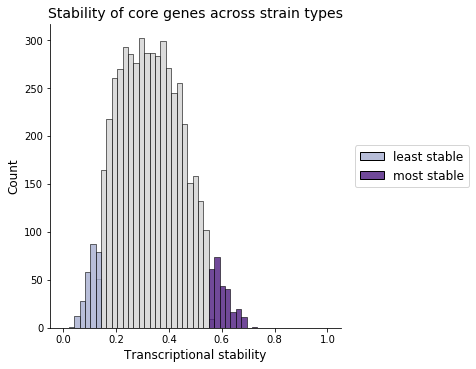

In [20]:
# Plot distribution of correlation scores
# This scores indicate how transcriptionally similar genes are across PAO1 and PA14 strains
fig_pao1 = sns.displot(
    data=pao1_corr_df,
    x="Transcriptional similarity across strains",
    hue="label",
    hue_order=["least stable", "most stable", ""],
    # label=["", "least stable", "most stable"],
    palette={"": "lightgrey", "least stable": "#a6aed0ff", "most stable": "#4e1c80"},
    legend=True,
    alpha=0.8,
    bins=np.linspace(0, 1, 50),
)
fig_pao1._legend.remove()

old_legend = fig_pao1._legend
handles = old_legend.legendHandles

legend = plt.legend(
    handles=[handles[0], handles[1]],
    labels=[fig_pao1._legend.texts[0].get_text(), fig_pao1._legend.texts[1].get_text()],
    bbox_to_anchor=(1.05, 0.6),
    loc="upper left",
    borderaxespad=0,
    fontsize=12,
)

plt.title("Stability of core genes across strain types", fontsize=14, y=1.1)
plt.xlabel("Transcriptional stability", fontsize=12)
plt.ylabel("Count", fontsize=12)

Text(12.502994791666666, 0.5, 'Count')

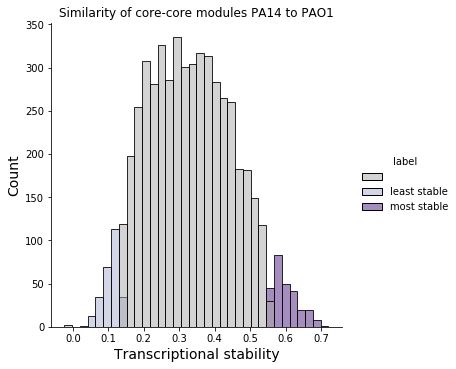

In [21]:
fig_pa14 = sns.displot(
    data=pa14_corr_df,
    x="Transcriptional similarity across strains",
    hue="label",
    palette={"": "darkgrey", "least stable": "#a6aed0ff", "most stable": "#4e1c80"},
)

plt.title("Similarity of core-core modules PA14 to PAO1")
plt.xlabel("Transcriptional stability", fontsize=14)
plt.ylabel("Count", fontsize=14)

**Takeaways:**

* Other highly stable genes are sdh suc lpd (central metabolism), ribosomal genes.
* RhlRI more stable than LasRI; pqsABCDE/MvfR in the middle.

### Compare most/least stable genes found mapping PAO1 > PA14 and PA14 > PAO1

As a check, we would expect that the most stable core genes are the same if we start with PAO1 gene ids and map to PA14 gene ids (`high_pao1_set`) versus if we start with PA14 gene ids and map to PAO1 gene ids (`high_pa14_set`). Similarly if we compare the least stable core genes.

Below we can see that all but a few genes overlap. These genes seem to have fallen slighly outside the bounds of what is considered most/least stable which is why they are not found in the other mapped set.

In [22]:
high_pao1 = pao1_most_stable
low_pao1 = pao1_least_stable

In [23]:
high_pa14 = pa14_most_stable
low_pa14 = pa14_least_stable

In [24]:
high_pao1.head()

,PA14 homolog id,Transcriptional similarity across strains,P-value,Name,label
PAO1 id,,,,,
PA4273,PA14_08730,0.720742,0.0,rplA,
PA4248,PA14_09000,0.693872,0.0,rplF,
PA4266,PA14_08820,0.691639,0.0,fusA1,
PA3821,PA14_14630,0.690141,0.0,secD,
PA4433,PA14_57590,0.688131,0.0,rplM,


In [25]:
high_pa14.head()

,PAO1 homolog id,Transcriptional similarity across strains,P-value,Name,label
PA14 id,,,,,
PA14_08730,PA4273,0.720760,0.0,rplA,
PA14_09000,PA4248,0.693909,0.0,rplF,
PA14_08820,PA4266,0.691710,0.0,fusA1,
PA14_14630,PA3821,0.690161,0.0,secD,
PA14_57590,PA4433,0.688134,0.0,rplM,


In [26]:
low_pao1.head()

,PA14 homolog id,Transcriptional similarity across strains,P-value,Name,label
PAO1 id,,,,,
PA0573,PA14_07440,0.135571,2.305768e-23,NaN,
PA2506,PA14_32250,0.135569,2.308553e-23,NaN,
PA2447,PA14_32970,0.135395,2.628461e-23,NaN,
PA0478,PA14_06250,0.134775,4.164841e-23,NaN,
PA2671,PA14_29550,0.134191,6.417359e-23,NaN,


In [27]:
low_pa14.head()

,PAO1 homolog id,Transcriptional similarity across strains,P-value,Name,label
PA14 id,,,,,
PA14_45020,PA1500,0.135814,1.959546e-23,NaN,
PA14_13240,PA3917,0.135716,2.107795e-23,moaD,
PA14_32970,PA2447,0.135274,2.929916e-23,NaN,
PA14_06250,PA0478,0.134577,4.914068e-23,NaN,
PA14_29550,PA2671,0.134306,6.003560e-23,NaN,


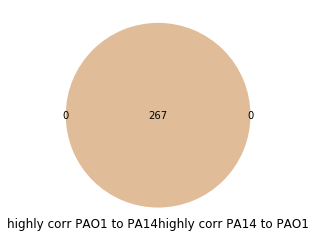

In [28]:
# Check if the highly correlated genes from PAO1 to PA14 are the same as the ones from PA14 to PAO1
high_pao1_set = set(high_pao1["PA14 homolog id"])
high_pa14_set = set(high_pa14.index)
venn2(
    [high_pao1_set, high_pa14_set],
    set_labels=("highly corr PAO1 to PA14", "highly corr PA14 to PAO1"),
)

In [29]:
unmapped_pao1_gene_ids = high_pao1_set.difference(high_pa14_set)
unmapped_pao1_gene_ids

set()

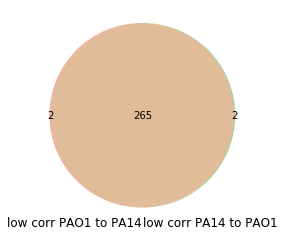

In [30]:
# Check if the lowly correlated genes from PAO1 to PA14 are the same as the ones from PA14 to PAO1
low_pao1_set = set(low_pao1["PA14 homolog id"])
low_pa14_set = set(low_pa14.index)
venn2(
    [low_pao1_set, low_pa14_set],
    set_labels=("low corr PAO1 to PA14", "low corr PA14 to PAO1"),
)

In [31]:
# There are unmapped ids using spell
unmapped_pa14_pao1_gene_ids = low_pa14_set.difference(low_pao1_set)
unmapped_pao1_pa14_gene_ids = low_pao1_set.difference(low_pa14_set)

In [32]:
# There are unmapped ids using spell
print(unmapped_pa14_pao1_gene_ids)
print(unmapped_pao1_pa14_gene_ids)

{'PA14_45020', 'PA14_13240'}
{'PA14_07440', 'PA14_32250'}


In [37]:
# Looks like 'PA14_07440', 'PA14_32250' homologs don't exist in our PAO1 compendium
pao1_corr_df[
    (pao1_corr_df["PA14 homolog id"] == "PA14_07440")
    & (pao1_corr_df["PA14 homolog id"] == "PA14_32250")
]

,PA14 homolog id,Transcriptional similarity across strains,P-value,Name,label
PAO1 id,,,,,


In [38]:
# Looks like this gene barely fell above the least stable threshold in PAO1
pa14_corr_df.loc[["PA14_45020", "PA14_13240"]]  # using spell data

,PAO1 homolog id,Transcriptional similarity across strains,P-value,Name,label
PA14 id,,,,,
PA14_45020,PA1500,0.135814,1.959546e-23,NaN,least stable
PA14_13240,PA3917,0.135716,2.107795e-23,moaD,least stable


In [35]:
# Save
fig_pao1.savefig(
    pao1_similarity_dist_filename,
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

fig_pa14.savefig(
    pa14_similarity_dist_filename,
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

In [36]:
# Save transcriptional similarity df
pao1_corr_df.to_csv(pao1_similarity_scores_filename, sep="\t")
pa14_corr_df.to_csv(pa14_similarity_scores_filename, sep="\t")

**Takeaways:**

The distribution plots are the distribution of correlation scores, which represent how correlated a core gene was with its homolog. As an example, say we have core gene PA0001, we can get its correlation profile (i.e. the row of the correlation matrix) that tells us which core genes PA0001 is highly and lowly correlated with. Then we can map PA0001 to its homolog in PA14 and get its correlation profile. Finally we can take the correlation of those correlation profile to determine how consistent PA0001's relationships are across strains. Genes with a high correlation score (right tail of the distribution) represent genes that are stable and are core genes that are related to the same set of core genes in PAO1 and PA14. While genes with a low correlation score (left tail of the distribution) represent genes that are unstable and are core genes that are not related to the same set of core genes in PAO1 and PA14.

Based on the distribution plots, we find that there exist a set of core genes that are stable across strain types and while there are others that are inconsistent across strain types.
See [KEGG enrichment analysis](5_KEGG_enrichment_of_stable_genes.ipynb) where we looked into which genes are most stable vs least stable.